In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('CC_data.csv')
data = np.array(df[df['ticker']=='BTC-USD']['high'])

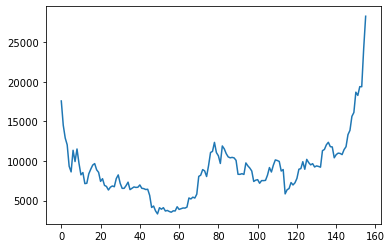

In [4]:
plt.figure()
plt.plot(data)
plt.show()

In [5]:
normalize_data=(data-np.mean(data))/np.std(data)  #标准化
normalize_data=normalize_data[:,np.newaxis]

In [6]:
time_step=20      
rnn_unit=10       #hidden layer units
batch_size=60     
input_size=1      
output_size=1     
lr=0.0006

In [7]:
train_x,train_y=[],[]
for i in range(len(normalize_data)-time_step-1):
    x=normalize_data[i:i+time_step]
    y=normalize_data[i+1:i+time_step+1]
    train_x.append(x.tolist())
    train_y.append(y.tolist()) 

In [8]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
X=tf.placeholder(tf.float32, [None,time_step,input_size])
Y=tf.placeholder(tf.float32, [None,time_step,output_size])

Instructions for updating:
non-resource variables are not supported in the long term


In [9]:
weights={
         'in':tf.Variable(tf.random_normal([input_size,rnn_unit])),
         'out':tf.Variable(tf.random_normal([rnn_unit,1]))
         }
biases={
        'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
        'out':tf.Variable(tf.constant(0.1,shape=[1,]))
        }

In [10]:
def lstm(batch):  
    w_in=weights['in']
    b_in=biases['in']
    input=tf.reshape(X,[-1,input_size]) 
    input_rnn=tf.matmul(input,w_in)+b_in
    input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit]) 
    cell=tf.nn.rnn_cell.BasicLSTMCell(rnn_unit)
    init_state=cell.zero_state(batch,dtype=tf.float32)
    output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn,initial_state=init_state, dtype=tf.float32)
    output=tf.reshape(output_rnn,[-1,rnn_unit]) 
    w_out=weights['out']
    b_out=biases['out']
    pred=tf.matmul(output,w_out)+b_out
    return pred,final_states

In [11]:
def train_lstm():
    global batch_size
#     pred,_=lstm(batch_size)

    with tf.variable_scope('lstm'):
        pred,_=lstm(batch_size) 
        
    loss=tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))
    train_op=tf.train.AdamOptimizer(lr).minimize(loss)
    saver=tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for i in range(100):
            step=0
            start=0
            end=start+batch_size
            while(end<len(train_x)):
                _,loss_=sess.run([train_op,loss],feed_dict={X:train_x[start:end],Y:train_y[start:end]})
                start+=batch_size
                end=start+batch_size

                if step%10==0:
                    print(i,step,loss_)
                    print("Save Model: ",saver.save(sess,'stock.model'))
                step+=1


In [12]:
train_lstm()

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
0 0 2.2695928
Save Model:  stock.model
1 0 2.0754416
Save Model:  stock.model
2 0 1.9044163
Save Model:  stock.model
3 0 1.745484
Save Model:  stock.model
4 0 1.5969218
Save Model:  stock.model
5 0 1.4579831
Save Model:  stock.model
6 0 1.3281133
Save Model:  stock.model
7 0 1.2068205
Save Model:  stock.model
8 0 1.093677
Save Model:  stock.model
9 0 0.9883329
Save Model:  stock.model
10 0 0.8905124
Save Model:  stock.model
11 0 0.7999922
Save Model:  stock.model
12 0 0.7165762
Save Model:  stock.model
13 0 0.6400732
Save Model:  stock.model
14 0 0.57028115
Save Model:  stock.model
15 0 0.5069773
Save Model:  stock.model
16 0 0.44991195
Save Model:  stock.model
17 0 0.3988066
Save Model:  stock.model
18 0 0.35335463
Save Model:  stock.model
19 0 0.31322333
Save Model:  stock.

In [13]:
def prediction():
#     pred,_=lstm(1)    
    with tf.variable_scope('lstm', reuse=True): 
        pred,_=lstm(1)
    saver=tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        
        module_file = tf.train.latest_checkpoint("./")
        saver.restore(sess, module_file) 

        prev_seq=train_x[-1]
        predict=[]
        
        for i in range(100):
            next_seq=sess.run(pred,feed_dict={X:[prev_seq]})
            predict.append(next_seq[-1])
            
            prev_seq=np.vstack((prev_seq[1:],next_seq[-1]))
        
        plt.figure()
        plt.plot(list(range(len(normalize_data))), normalize_data, color='b')
        plt.plot(list(range(len(normalize_data), len(normalize_data) + len(predict))), predict, color='r')
        plt.show()

INFO:tensorflow:Restoring parameters from ./stock.model


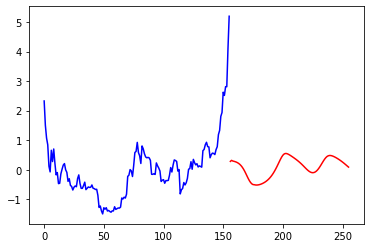

In [14]:
prediction()